In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install missingno
import missingno as msno

Note: you may need to restart the kernel to use updated packages.


# Breed1 & Breed2

Breed1 and Breed2 are from the same domain, which can be leveraged by building a graph from it.

- we create a directed graph from the Breed1 -> Breed2
- we create a word2vec model 
- we use the model for the edges

In [3]:
train = pd.read_csv("data/train.csv")
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   
3             2  ...       1         1  150  41401   
4             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [4]:
breed = pd.read_csv("data/breed_labels.csv")
breed.head()

BreedID  Type         BreedName
0        1     1     Affenpinscher
1        2     1      Afghan Hound
2        3     1  Airedale Terrier
3        4     1            Akbash
4        5     1             Akita

In [5]:
missing_values = {col: train[col].isnull().sum() for col in train.columns}

missing_values["Breed1"], missing_values["Breed2"]

(0, 0)

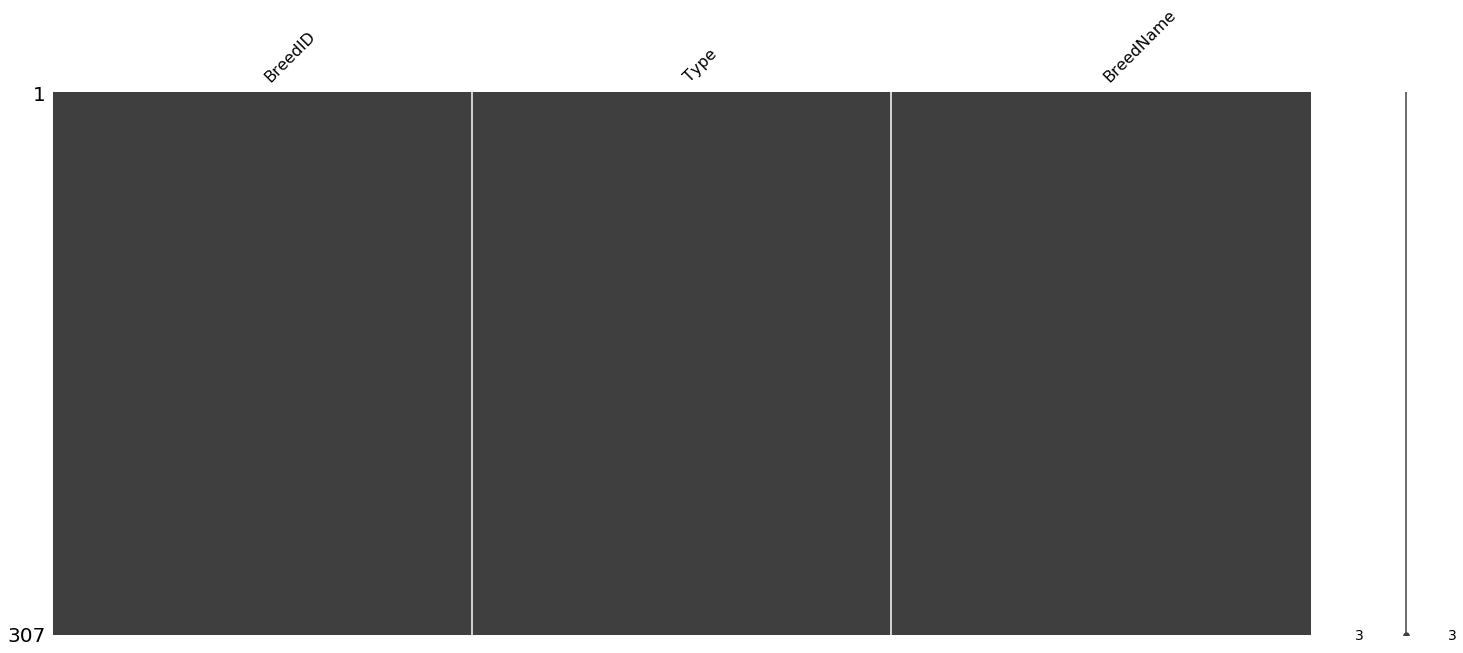

In [6]:
msno.matrix(breed)

In [7]:
len(breed)

307

<Figure size 720x720 with 0 Axes>

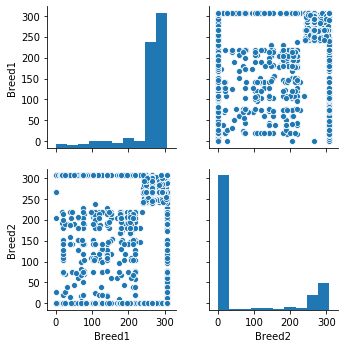

In [45]:
viz = train[["Breed1", "Breed2"]]
plt.figure(figsize=(10,10))
sns.pairplot(data=viz)

As both breed1 and breed2 use the breed df we can use these columns to create relations between them.

If breed1 and breed2 are in the same record, add one to the weight in the breed graph to the breed1 -> breed2 edge.
(breed graph is a fully connected graph between the breed values).

Then the graph gets embedded. This embedding might even help with the uneven data distribution.

In [8]:
b1_count = train["Breed1"].value_counts()
b2_count = train["Breed2"].value_counts()
breed_mod = breed.copy()
breed_mod.loc[-1] = [0, 0, "NoType"]
breed_keys = sorted(list(set(list(b1_count.keys()) + list(b2_count.keys()))))
breed_counts = {breed_mod[breed_mod["BreedID"] == b]["BreedName"].values[0]: 
                [b1_count.get(b, 0), b2_count.get(b, 0)] for b in breed_keys}
breed_counts

{'NoType': [5, 10762],
 'Affenpinscher': [2, 1],
 'Afghan Hound': [0, 1],
 'Airedale Terrier': [1, 0],
 'Akbash': [0, 1],
 'Akita': [2, 2],
 'American Bulldog': [1, 0],
 'American Staffordshire Terrier': [3, 2],
 'American Water Spaniel': [2, 0],
 'Australian Cattle Dog/Blue Heeler': [0, 2],
 'Australian Kelpie': [9, 0],
 'Australian Shepherd': [1, 2],
 'Australian Terrier': [6, 1],
 'Basenji': [6, 3],
 'Basset Hound': [9, 2],
 'Beagle': [90, 16],
 'Bearded Collie': [1, 3],
 'Bedlington Terrier': [1, 0],
 'Belgian Shepherd Dog Sheepdog': [2, 3],
 'Belgian Shepherd Laekenois': [3, 1],
 'Belgian Shepherd Malinois': [26, 17],
 'Black Labrador Retriever': [8, 0],
 'Black Mouth Cur': [3, 0],
 'Bluetick Coonhound': [0, 1],
 'Border Collie': [26, 11],
 'Border Terrier': [0, 1],
 'Boston Terrier': [5, 0],
 'Boxer': [10, 4],
 'Bull Terrier': [16, 2],
 'Bullmastiff': [12, 2],
 'Cattle Dog': [1, 0],
 'Cavalier King Charles Spaniel': [2, 1],
 'Chihuahua': [37, 7],
 'Chinese Crested Dog': [1, 0],
 

In [9]:
%pip install networkx
import networkx as nx

Note: you may need to restart the kernel to use updated packages.


In [10]:
train_breed = train[["Breed1", "Breed2"]]
edges_df = train_breed.groupby(train_breed.columns.tolist()).size() \
                .reset_index().rename(columns={0:"Count"})
edges_df["NormalizedCount"] = edges_df["Count"] / max(edges_df["Count"])
edges_df = edges_df.drop("Count", axis=1)
edges_df.head()

Breed1  Breed2  NormalizedCount
0       0      26         0.000221
1       0     205         0.000221
2       0     266         0.000221
3       0     307         0.000441
4       1       0         0.000441

In [11]:
breed_mod = breed.copy()
breed_mod.loc[-1] = [0, 0, "NoType"]


G=nx.DiGraph()
dog_nodes = []
cat_nodes = []
for breed_id, animal_type, breed_name in breed_mod.values:
    node = G.add_node(breed_id, type=animal_type, breed_name=breed_name)
    if animal_type == 1:
        dog_nodes.append(node)
    elif animal_type == 2:
        cat_nodes.append(node)
        
# One way edges to the graphs with weight = number of breed1->breed2 connections in the dataset 
for edge in edges_df.values:
    G.add_edge(edge[0], edge[1], weight=edge[2])

G = nx.relabel_nodes(G, {i: G.node[i]['breed_name'] for i in G.nodes()})

G_dogs = G.copy()
G_cats = G.copy()
G_dogs.remove_nodes_from(cat_nodes)
G_cats.remove_nodes_from(dog_nodes)

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >.05]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=.05]

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


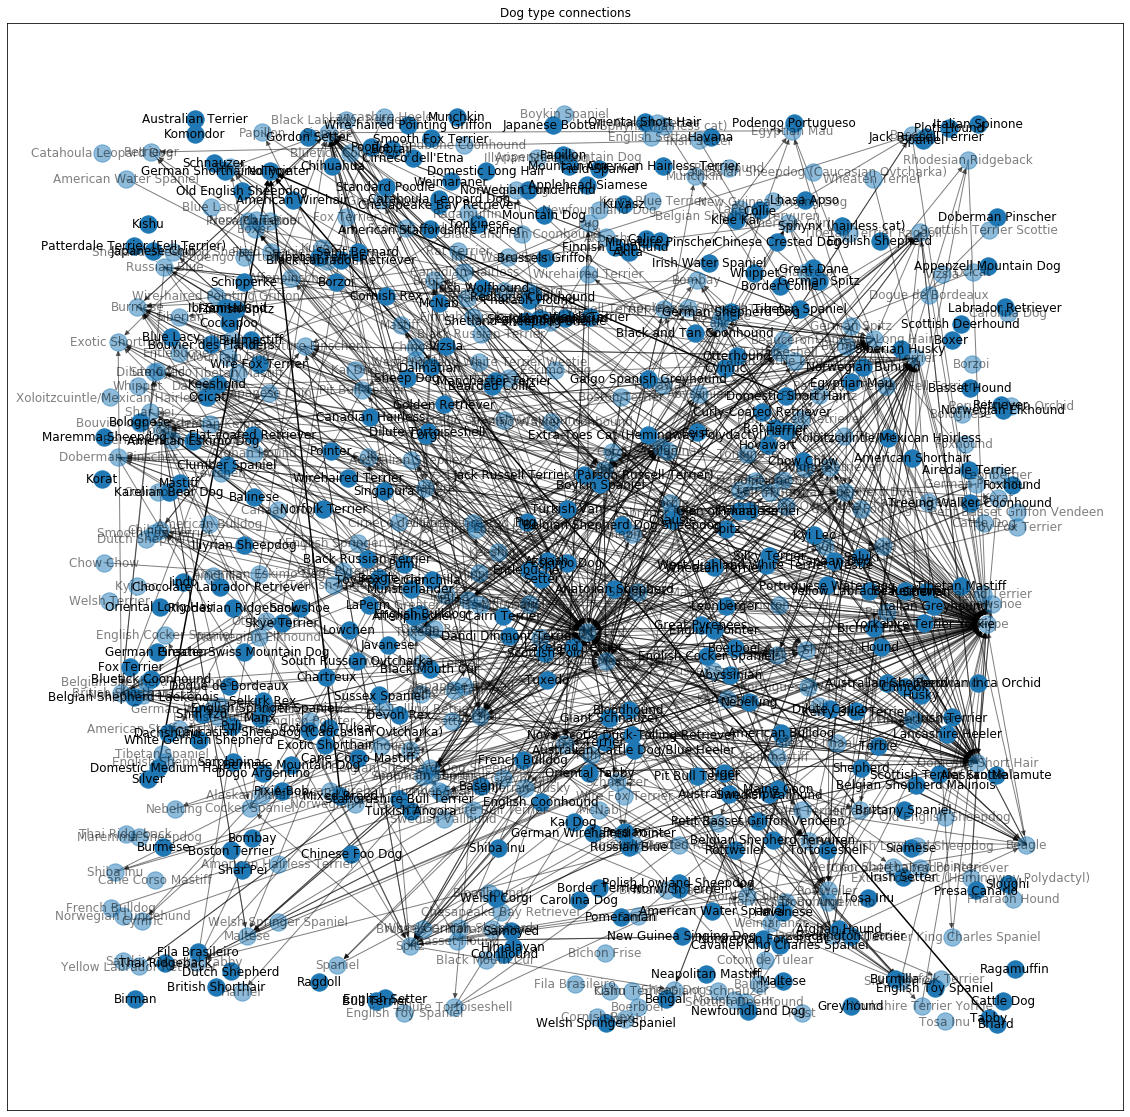

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
ax.set_title("Dog type connections")
nx.draw_networkx(G_dogs, ax=ax, pos=nx.random_layout(G_dogs), edgelist=esmall,
                    width=1,alpha=0.5, style="dotted")
nx.draw_networkx(G_dogs, ax=ax, pos=nx.random_layout(G_dogs), edgelist=elarge,
                    width=1.5)

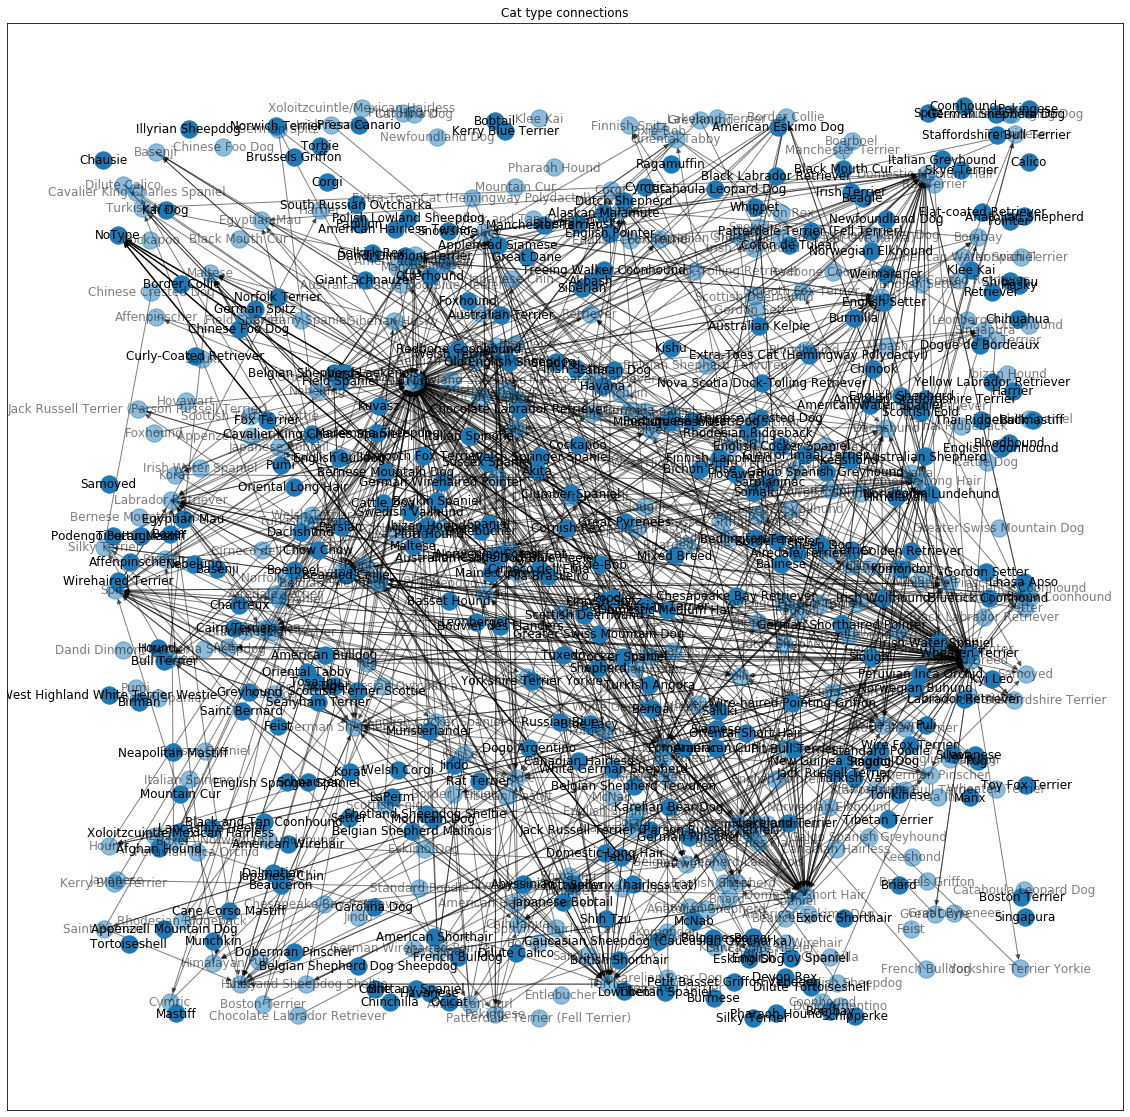

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.set_title("Cat type connections")
nx.draw_networkx(G_cats, ax=ax, pos=nx.random_layout(G_cats), edgelist=esmall,
                    width=1,alpha=0.5, style="dotted")
nx.draw_networkx(G_cats, ax=ax, pos=nx.random_layout(G_cats), edgelist=elarge,
                    width=1.5)

#### This finishes the creation of the graph, but we want the representation of the Breed1->Breed2 edge in our model, so we need to modify the graph.

In [14]:
%pip install node2vec
from node2vec import Node2Vec

Note: you may need to restart the kernel to use updated packages.


In [15]:
import ast

def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return
    
dim = 40

# This is the line graph, it computes edge embeddings on directed graphs, but due to processing limitations
# we are going to be using embedders from the node2vec lib
# https://github.com/eliorc/node2vec/blob/master/node2vec/edges.py

G_ = nx.line_graph(G)
mapping = {node: str(node) for node in G_.nodes()}
G_ = nx.relabel_nodes(G_,mapping)

node2vec = Node2Vec(G_, walk_length = 10, dimensions= dim, num_walks = 100, p = 0.25, q = 4, workers = 3)
model = node2vec.fit(iter = 1)

e2v_embeddings = pd.DataFrame(columns = ["Breed1Label", "Breed2Label"] + ["Dim_%d" % i for i in range(dim)])
for i, node_name in enumerate(G_.nodes()):
    breed1, breed2 = parse_tuple(node_name)
    e2v_embeddings.loc[i] = [breed1, breed2] + list(model[node_name])
e2v_embeddings.head()

Computing transition probabilities: 100%|██████████| 812/812 [00:01<00:00, 585.58it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Breed1Label                Breed2Label     Dim_0     Dim_1     Dim_2  \
0  Affenpinscher                     NoType  0.574912  0.557264  0.293638   
1         NoType  Belgian Shepherd Malinois  0.672766  0.714291  0.049097   
2         NoType                   Shih Tzu  1.294920  0.276685 -1.048461   
3         NoType        Domestic Short Hair  0.636809  0.654361 -0.109887   
4         NoType                Mixed Breed -0.448946  0.384778  0.324813   

      Dim_3     Dim_4     Dim_5     Dim_6     Dim_7  ...    Dim_30    Dim_31  \
0  0.209106  0.570213 -0.120832  0.786186 -0.094690  ...  1.224890  0.620445   
1  0.780057  1.082426  0.034898 -0.063140 -0.510560  ... -0.353716  1.440732   
2 -0.469154 -0.028311 -0.541451 -0.008093 -0.604631  ... -0.317106  0.248123   
3  0.430686  0.815048 -0.719086  0.187176 -0.236148  ...  0.084298  0.646951   
4  0.510886  0.627715 -0.320989  0.502013 -0.100145  ...  0.023142  0.122083   

     Dim_32    Dim_33    Dim_34    Dim_35    Dim_36    Dim_37    Dim_38  \
0 -0.499310 -0.281757  0.433180  0.946346  0.240397 -0.017135  0.145054   
1 -0.706550 -0.782077 -0.286012  0.652576  0.997873  0.602494 -0.987657   
2 -0.639539 -0.665985 -0.768109  1.651832  0.839899 -0.479795 -1.672535   
3 -0.513259  0.058785 -0.308372  1.059758 -0.763401  1.164428 -0.591806   
4 -0.010629 -0.430644 -0.030139  0.896743 -0.015310 -0.343936 -0.177828   

     Dim_39  
0  0.617572  
1  0.716822  
2  0.850043  
3  1.402010  
4  0.271575  

[5 rows x 42 columns]

In [16]:
def label_to_int(label):
    if label == "NoType":
        return 0
    return breed[breed["BreedName"] == label]["BreedID"].values[0]

e2v_embeddings["Breed1Int"] = e2v_embeddings["Breed1Label"].apply(label_to_int)
e2v_embeddings["Breed2Int"] = e2v_embeddings["Breed2Label"].apply(label_to_int)

embedding_df = pd.merge(train[["Breed1", "Breed2"]], e2v_embeddings,  how='left', left_on=['Breed1','Breed2'], right_on = ['Breed1Int','Breed2Int'])
embedding_df.head()

Breed1  Breed2           Breed1Label Breed2Label     Dim_0     Dim_1  \
0     299       0                 Tabby      NoType  0.090177  0.022977   
1     265       0  Domestic Medium Hair      NoType  0.079209 -0.014196   
2     307       0           Mixed Breed      NoType  0.192083  0.083409   
3     307       0           Mixed Breed      NoType  0.192083  0.083409   
4     307       0           Mixed Breed      NoType  0.192083  0.083409   

      Dim_2     Dim_3     Dim_4     Dim_5  ...    Dim_32    Dim_33    Dim_34  \
0 -0.063052  0.025025 -0.135949 -0.202324  ...  0.088034 -0.180406 -0.252656   
1 -0.216709 -0.173209 -0.061701 -0.112663  ... -0.172022  0.050966 -0.278412   
2  0.046609  0.225747  0.326776  0.155327  ... -0.056385 -0.249015 -0.171138   
3  0.046609  0.225747  0.326776  0.155327  ... -0.056385 -0.249015 -0.171138   
4  0.046609  0.225747  0.326776  0.155327  ... -0.056385 -0.249015 -0.171138   

     Dim_35    Dim_36    Dim_37    Dim_38    Dim_39  Breed1Int  Breed2Int  
0  0.206001 -0.353707  0.567248 -0.133768 -0.355605        299          0  
1  0.087475 -0.234264  0.380273  0.012020 -0.097268        265          0  
2  0.893443  0.465276 -0.416741 -0.099546  0.233393        307          0  
3  0.893443  0.465276 -0.416741 -0.099546  0.233393        307          0  
4  0.893443  0.465276 -0.416741 -0.099546  0.233393        307          0  

[5 rows x 46 columns]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Creating T-SNE model...
T-SNE complete


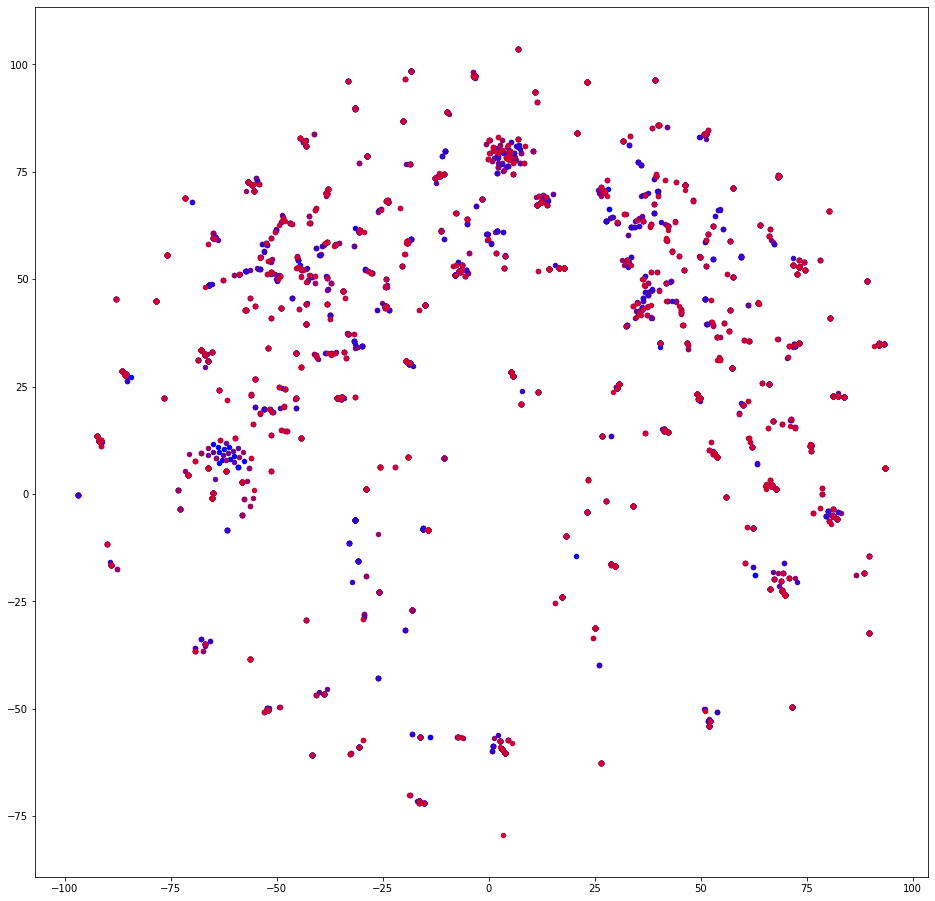

In [44]:
from sklearn.manifold import TSNE

viz = train[["AdoptionSpeed"]].join(embedding_df)

keys = {adoption_speed: viz[viz["AdoptionSpeed"] == adoption_speed][["Breed1Label", "Breed2Label"]].values for adoption_speed in viz["AdoptionSpeed"].unique()}

tokens = []
labels = []
adoption_speed = []

for key, array in keys.items():
    for breed1, breed2 in array:
        tokens.append(model[str((breed1, breed2))])
        labels.append("%s -> %s" % (breed1, breed2))
        adoption_speed.append(key)

print("Creating T-SNE model...")
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1000, random_state=23)
new_values = tsne_model.fit_transform(tokens)
print("T-SNE complete")

colors = [tuple(np.array([1,0,0])*alpha + np.array([0,0,1])*(1-alpha)) for alpha in np.arange(0, 1, 0.2)]

x = []
y = []

for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i], s=20, color=colors[adoption_speed[i]])
#     plt.annotate(labels[i],
#                  xy=(x[i], y[i]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')

plt.show()

It seems like the vectorspace created from the breed1->breed2 edges can be levaraged by TSNE (there are blue zones separed from red and blue is type 0 adoption speed), so there is no reason to belive a supervised model could not make use of it.